In [1]:
import warnings
warnings.simplefilter(action='ignore')
from numpy.random import uniform
from numpy.linalg import norm
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import stratified_resample
import scipy.stats
%matplotlib inline
from measurements import get_measurements

In [2]:
X,Y = get_measurements()
X,Y  = X[2:], Y[2:]
#let there be no measurement at 12th frame
no_meas_idx = [ 11 ]
print(len(X))
print(len(Y))
x_gt = [369,343,315,304,284,268,255,243,234,229,217,201,205,197,192]
y_gt = [149,189,238,256,291,329,346,314,277,259,230,214,197,181,167]


14
14


In [3]:
#Filter implementation

"Acceleration as the the process noise"

T = 1/30
meas = np.zeros((2, len(X)),dtype = 'float32')
for i in range(meas.shape[1]):
    meas[0,i],meas[1,i] = X[i],Y[i]
H_MAT = np.matrix(([1 ,0, T, 0],[0 ,1, 0, T],[0 ,0 ,1, 0],[0 ,0 ,0, 1]))
m_sigma1,m_sigma2  = 49,9

s_sigma_x, s_sigma_y, s_sigma_vx, s_sigma_vy = 100,10000,100,10000
R = np.matrix(([m_sigma1,0],[0,m_sigma2]))
M_MAT = np.matrix(([1,0,0,0],[0,1,0,0]))
S_0 = np.matrix(([s_sigma_x,0,0,0],[0,s_sigma_y,0,0],[0,0,s_sigma_vx,0],[0,0,0,s_sigma_vy]))
Q_MAT = np.matrix(([10,0,0,0],[0,1000,0,0],[0,0,10,0],[0,0,0,100000]))

S_arr, X_hat = [],[]
X_hat.append(np.concatenate((meas[:,0],np.array((-1*400,100)))))
X_hat[0] = X_hat[0].reshape((4,1))
S_arr.append(S_0)
i = 0
for j in range(1,len(X) + len(no_meas_idx)):
    #predict step
    X_pred = H_MAT@X_hat[j-1]
    S_pred = H_MAT@S_arr[j-1]@np.transpose(H_MAT) + Q_MAT
    #print(S_pred)
    if j in no_meas_idx:
        X_upd = H_MAT@X_hat[j-1]
        S_upd = H_MAT@S_arr[j-1]@np.transpose(H_MAT) + Q_MAT
        S_arr.append(S_upd)
        X_hat.append(X_upd)
    #update step
    if j not in no_meas_idx:
        kalman_gain = S_pred@np.transpose(M_MAT)@np.linalg.pinv(M_MAT@S_pred@np.transpose(M_MAT) + R)
        #print(kalman_gain)
        X_upd = X_pred + kalman_gain@(meas[:,i].reshape(2,1) - M_MAT@X_pred)
        S_upd = S_pred - kalman_gain@M_MAT@S_pred
        #print(S_upd)
        S_arr.append(S_upd)
        X_hat.append(X_upd)
        i = i+1

In [4]:
X_hats ,Y_hats, Vx_hats,Vy_hats = [],[],[],[]
for i in range(len(X_hat)):
    X_hats.append(X_hat[i][0])
    Y_hats.append(X_hat[i][1])
    Vx_hats.append(X_hat[i][2])
    Vy_hats.append(X_hat[i][3])

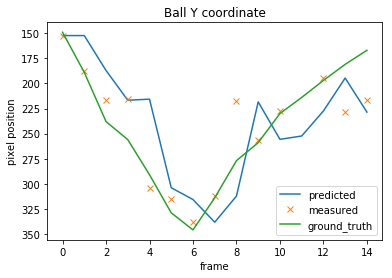

In [5]:
meas_Y = []
p=0
for k in range(0,len(X)+ len(no_meas_idx)):
    if k in no_meas_idx:
        meas_Y.append(np.nan)
    else:
        meas_Y.append(Y[p])
        p= p+1
plt.plot(Y_hats)
plt.plot(meas_Y, 'x')
y_gt = [149,189,238,256,291,329,346,314,277,259,230,214,197,181,167]
plt.gca().invert_yaxis()
plt.plot(y_gt)
plt.title("Ball Y coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")
plt.legend(["predicted","measured","ground_truth"])
plt.show()

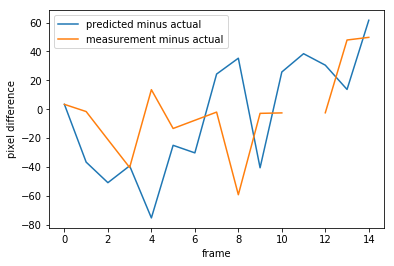

In [6]:
diffs_y = [(Y_hats[i] - y_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_y)

diffs_y_meas = [(meas_Y[i] - y_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_y_meas)
#plt.xlim([0,6])
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()
diffs_y_meas.pop(11)
diffs_y.pop(11)
k1 = diffs_y

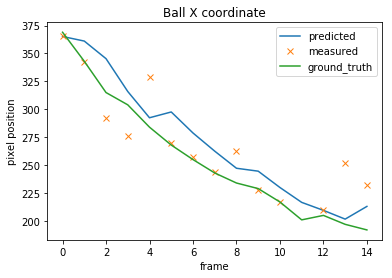

In [7]:
meas_X = []
p=0
for k in range(0,len(X)+ len(no_meas_idx)):
    if k in no_meas_idx:
        meas_X.append(np.nan)
    else:
        meas_X.append(X[p])
        p= p+1
plt.plot(X_hats)
plt.title("Ball X coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")

plt.plot(meas_X, 'x')
x_gt = [369,343,315,304,284,268,255,243,234,229,217,201,205,197,192]
plt.plot(x_gt)
plt.legend(["predicted","measured","ground_truth"])
plt.show()

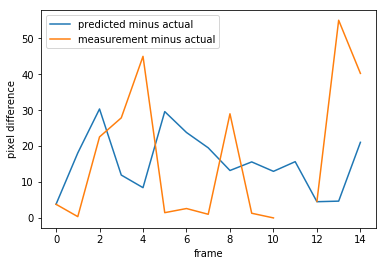

matrix([[15.66577423]])

In [8]:
diffs_x = [abs(X_hats[i] - x_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_x)

diffs_x_meas = [abs(meas_X[i] - x_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_x_meas)
#plt.ylim([0,70])
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()
diffs_x_meas.pop(11)
diffs_x.pop(11)


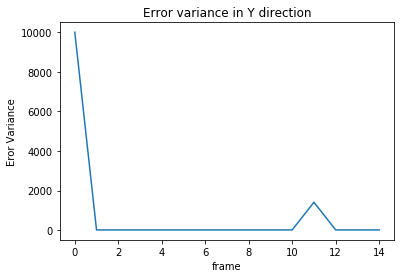

In [9]:
p = []
for item in S_arr:
    p.append((item[1,1]))
plt.plot(p)
plt.ylabel("Eror Variance")
plt.xlabel("frame")
plt.title("Error variance in Y direction")
plt.show()

In [10]:
"""
Accelertion incorporated in the control input and also as a process noise
"""

T = 1/30
meas = np.zeros((2, len(X)),dtype = 'float32')
for i in range(meas.shape[1]):
    meas[0,i],meas[1,i] = X[i],Y[i]
H_MAT = np.matrix(([1 ,0, T, 0],[0 ,1, 0, T],[0 ,0 ,1, 0],[0 ,0 ,0, 1]))
m_sigma1,m_sigma2  = 25,150

s_sigma_x, s_sigma_y, s_sigma_vx, s_sigma_vy = 100,1000,100,10000
R = np.matrix(([m_sigma1,0],[0,m_sigma2]))
M_MAT = np.matrix(([1,0,0,0],[0,1,0,0]))
S_0 = np.matrix(([s_sigma_x,0,0,0],[0,s_sigma_y,0,0],[0,0,s_sigma_vx,0],[0,0,0,s_sigma_vy]))
Q_MAT = np.matrix(([10,0,0,0],[0,100,0,0],[0,0,10,0],[0,0,0,10000]))


S_arr, X_hat = [],[]
X_hat.append(np.concatenate((meas[:,0],np.array((-1*600,900)))))
X_hat[0] = X_hat[0].reshape((4,1))
B = np.transpose(np.matrix(([T*T/2 , T*T/2, T ,T])))
acc = 5000
S_arr.append(S_0)
i = 0
for j in range(1,len(X) + len(no_meas_idx)):
    #predict step
    X_pred = H_MAT@X_hat[j-1] + np.multiply(B, np.transpose(np.matrix(([0,acc,0,acc]))))
    S_pred = H_MAT@S_arr[j-1]@np.transpose(H_MAT) + Q_MAT
    #print(S_pred)
    if j in no_meas_idx:
        X_upd = H_MAT@X_hat[j-1] + np.multiply(B, np.transpose(np.matrix(([0,acc,0,acc]))))
        S_upd = H_MAT@S_arr[j-1]@np.transpose(H_MAT) + Q_MAT
        S_arr.append(S_upd)
        X_hat.append(X_upd)
    #update step
    if j not in no_meas_idx:
        kalman_gain = S_pred@np.transpose(M_MAT)@np.linalg.pinv(M_MAT@S_pred@np.transpose(M_MAT) + R)
        #print(kalman_gain)
        X_upd = X_pred + kalman_gain@(meas[:,i].reshape(2,1) - M_MAT@X_pred)
        S_upd = S_pred - kalman_gain@M_MAT@S_pred
        #print(S_upd)
        S_arr.append(S_upd)
        X_hat.append(X_upd)
        i = i+1

In [11]:
X_hats ,Y_hats, Vx_hats,Vy_hats = [],[],[],[]
for i in range(len(X_hat)):
    X_hats.append(X_hat[i][0])
    Y_hats.append(X_hat[i][1])
    Vx_hats.append(X_hat[i][2])
    Vy_hats.append(X_hat[i][3])

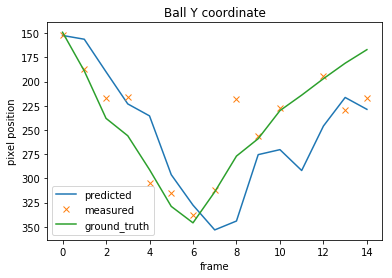

In [12]:
meas_Y, p = [],0
for k in range(0,len(X)+ len(no_meas_idx)):
    if k in no_meas_idx:
        meas_Y.append(np.nan)
    else:
        meas_Y.append(Y[p])
        p= p+1
plt.gca().invert_yaxis()
plt.plot(Y_hats)
plt.plot(meas_Y, 'x')
plt.plot(y_gt)
plt.title("Ball Y coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")
plt.legend(["predicted","measured","ground_truth"])
plt.show()

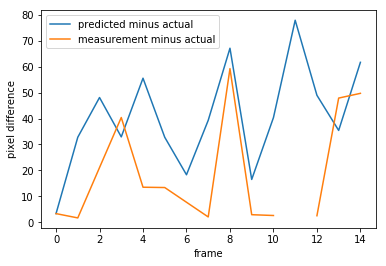

In [13]:
diffs_y = [abs(Y_hats[i] - y_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_y)

diffs_y_meas = [abs(meas_Y[i] - y_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_y_meas)
#plt.xlim([0,6])
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()
diffs_y_meas.pop(11)
diffs_y.pop(11)
k2 = diffs_y

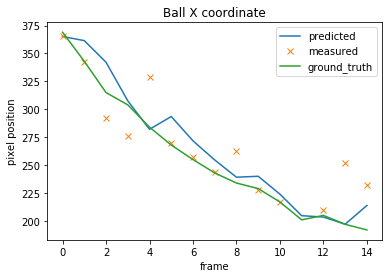

In [14]:
meas_X = []
p=0
for k in range(0,len(X)+ len(no_meas_idx)):
    if k in no_meas_idx:
        meas_X.append(np.nan)
    else:
        meas_X.append(X[p])
        p= p+1
plt.plot(X_hats)
plt.title("Ball X coordinate")
plt.xlabel("frame")
plt.ylabel("pixel position")
plt.plot(meas_X, 'x')
plt.plot(x_gt)
plt.legend(["predicted","measured","ground_truth"])
plt.show()

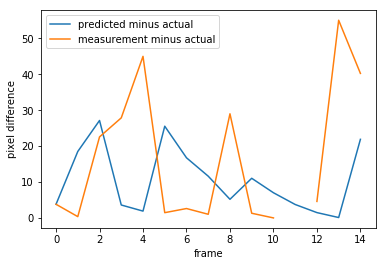

In [15]:
diffs_x = [abs(X_hats[i] - x_gt[i]) for i in range(len(y_gt))]
plt.plot(diffs_x)

diffs_x_meas = [abs(meas_X[i] - x_gt[i]) for i in range(len(y_gt)) ]

plt.plot(diffs_x_meas)
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.legend(["predicted minus actual","measurement minus actual"])
plt.show()



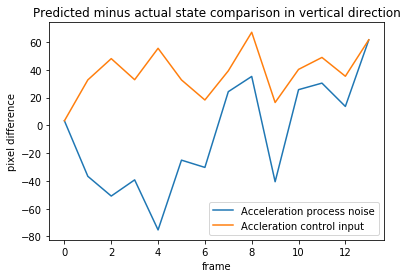

In [16]:
plt.plot(k1)
plt.plot(k2)
plt.ylabel("pixel difference")
plt.xlabel("frame")
plt.title("Predicted minus actual state comparison in vertical direction")
plt.legend(["Acceleration process noise","Accleration control input"])
plt.show()
